## importing modules

In [15]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader

## importing the data

In [2]:
path = 'D:/project/Python/predication/train.csv'
df = pd.read_csv(path)
df.head(5)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


## Data preprocessing & EDA

In [3]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['store', 'item', 'date'])
df.head(5)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


#### Store wise sales 

C:\Users\24265\AppData\Local\Temp\ipykernel_19392\1849702285.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_sales = df.groupby([pd.Grouper(key='date', freq='Q'), 'store'])['sales'].sum().reset_index()


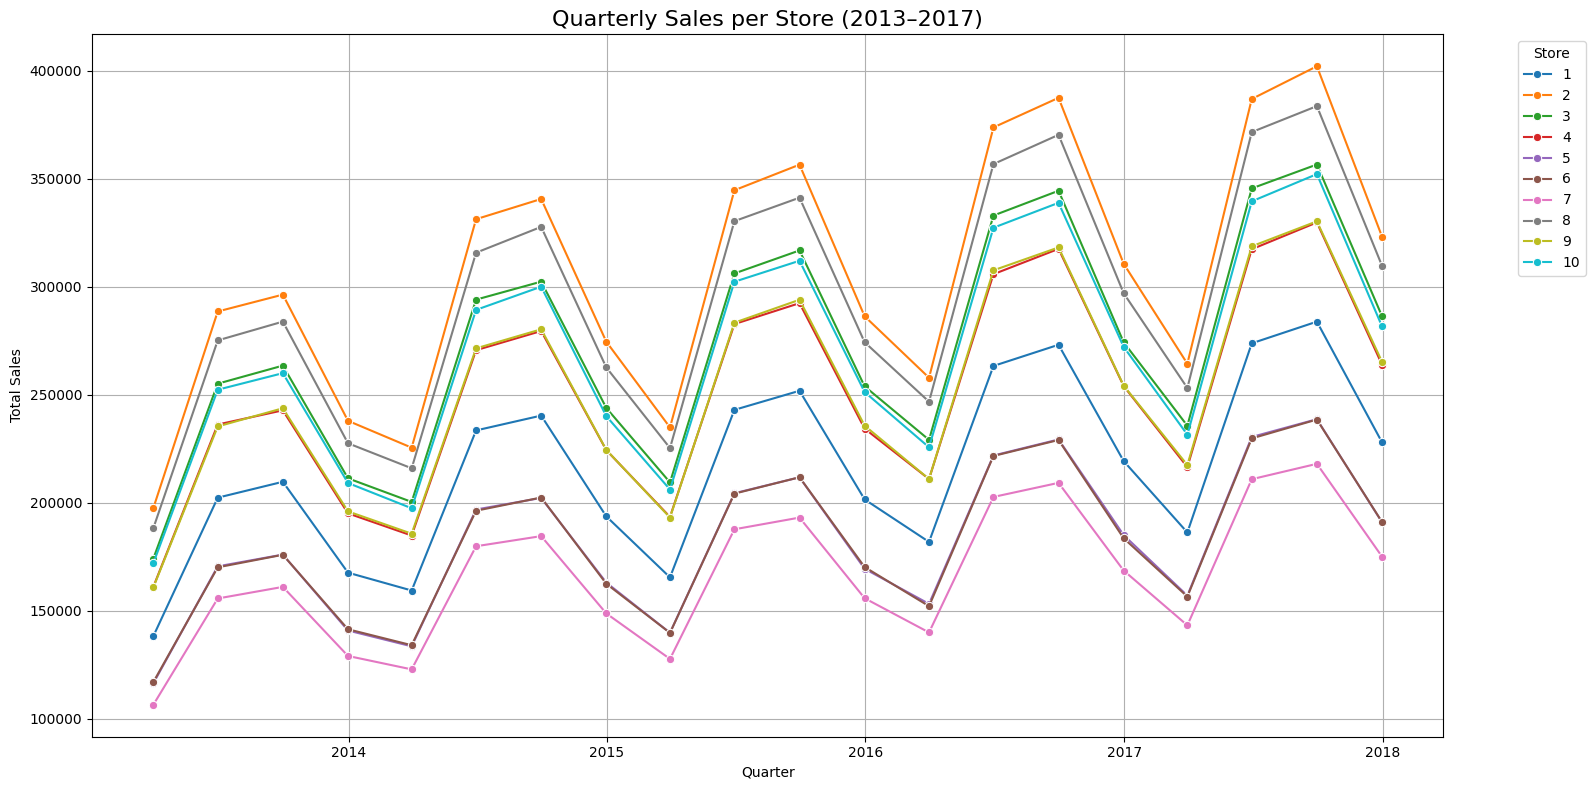

In [ ]:

# Group by quarterly periods and store, summing sales
quarterly_sales = df.groupby([pd.Grouper(key='date', freq='Q'), 'store'])['sales'].sum().reset_index()

# Plot with Seaborn
plt.figure(figsize=(16, 8))
sns.lineplot(data=quarterly_sales, x='date', y='sales', hue='store', palette='tab10', marker='o')

# Set the plot
plt.title('Quarterly Sales per Store (2013–2017)', fontsize=16)
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.legend(title='Store', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

#### Store-Item Wise sales

C:\Users\24265\AppData\Local\Temp\ipykernel_10612\3738330916.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_sales_stores_item = df.groupby([pd.Grouper(key='date', freq='Q'), 'store', 'item'])['sales'].sum().reset_index()


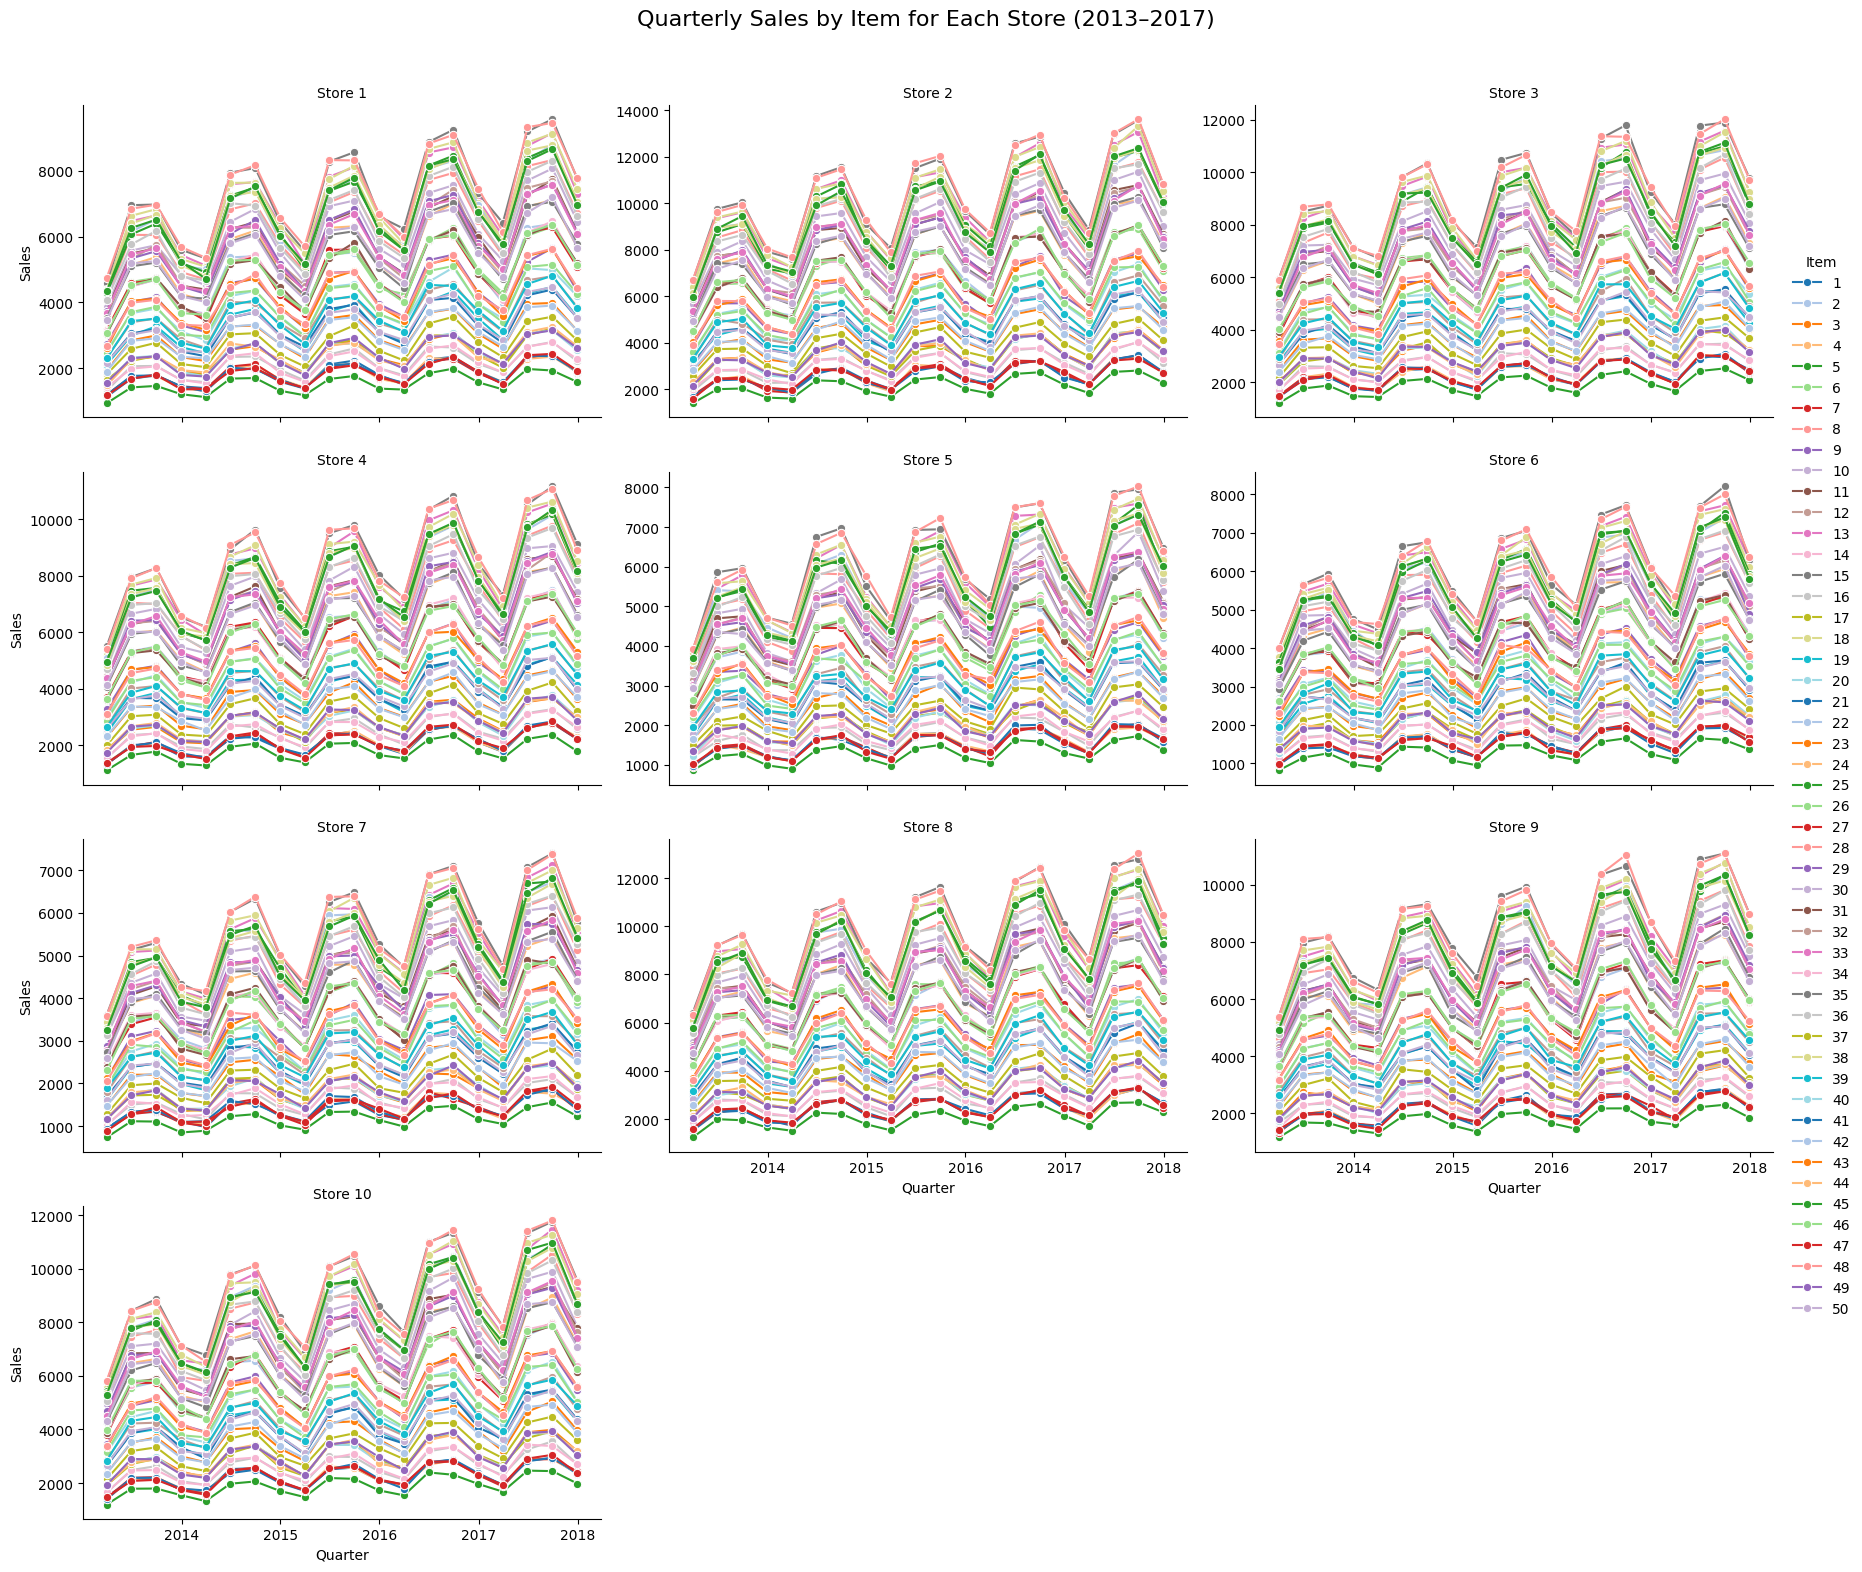

In [17]:

# Group by quarterly period, store, and item
quarterly_sales_stores_item = df.groupby([pd.Grouper(key='date', freq='Q'), 'store', 'item'])['sales'].sum().reset_index()

# Plot: One subplot per store, each line is an item
g = sns.FacetGrid(quarterly_sales_stores_item, col="store", col_wrap=3, height=4, aspect=1.5, sharey=False)
g.map_dataframe(sns.lineplot, x="date", y="sales", hue="item", palette="tab20", marker='o')

# Enhance appearance
g.set_titles("Store {col_name}")
g.set_axis_labels("Quarter", "Sales")
g.add_legend(title="Item")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Quarterly Sales by Item for Each Store (2013–2017)", fontsize=16)

# Show plot
plt.show()

In [ ]:
# Understanding the data pattern item/store/year wise

df['year'] = df['date'].dt.year

# Group by year, store, item — then aggregate
sales_summary = df.groupby(['year', 'store', 'item'])['sales'].agg(
    avg_sales='mean',
    max_sales='max',
    min_sales='min'
).reset_index()

# Display the first few rows
print(sales_summary.head(5))

      year  store  item  avg_sales  max_sales  min_sales
0     2013      1     1  16.506849         38          5
1     2013      1     2  43.934247         82         13
2     2013      1     3  27.671233         50         10
3     2013      1     4  16.561644         34          4
4     2013      1     5  13.704110         30          3
...    ...    ...   ...        ...        ...        ...
2495  2017     10    46  73.868493        125         34
2496  2017     10    47  28.106849         56          6
2497  2017     10    48  65.060274        120         28
2498  2017     10    49  36.726027         69         12
2499  2017     10    50  82.904110        150         32

[2500 rows x 6 columns]


## Preparing Dataset

In [ ]:
window_size = 30

# Container for dfing samples
X_list = []
y_list = []

# Group by store and item
for (store, item), group in df.groupby(['store', 'item']):
    sales_series = group['sales'].values

    for i in range(len(sales_series) - window_size):
        X_list.append(sales_series[i:i+window_size])
        y_list.append(sales_series[i+window_size])

# Convert to numpy arrays
X = np.array(X_list, dtype=np.float32).reshape(-1, window_size, 1)
y = np.array(y_list,dtype=np.float32).reshape(-1, 1)

X_df, X_val, y_df, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
batch_size = 64
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Model Building

In [8]:

class SalesLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(SalesLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]) 


## Model Training

In [ ]:
def df_model(model, df_loader, val_loader, optimizer, criterion, epochs=10, device='cpu'):
    model.to(device)

    for epoch in range(epochs):
        model.df()
        df_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_preds, val_targets = [], []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                preds = model(X_batch)
                val_preds.append(preds.detach().cpu().numpy())
                val_targets.append(y_batch.detach().cpu().numpy())

        val_preds = np.concatenate(val_preds, axis=0)
        val_targets = np.concatenate(val_targets, axis=0)

        val_mae = mean_absolute_error(val_targets, val_preds)
        val_mse = np.mean((val_targets - val_preds) ** 2)
        val_r2 = r2_score(val_targets, val_preds)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss / len(train_loader):.4f} | "
              f"Val MSE: {val_mse:.4f} | "
              f"Val MAE: {val_mae:.4f} | "
              f"Val R²: {val_r2:.4f}")

## Inference

In [9]:
# Step 1: Load the trained model
def load_model(model_class, model_path, device='cpu'):
    model = model_class(input_size=1, hidden_size=64, num_layers=2)  # Initialize with the same parameters
    model.load_state_dict(torch.load(model_path))  # Load saved weights
    model.to(device)  # Move model to the desired device (GPU or CPU)
    model.eval()  # Set model to evaluation mode
    return model

In [10]:
# Step 2: Load  model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_path = 'sales_model.pth' 
model = load_model(SalesLSTM, model_path=model_path)

NameError: name 'SalesLSTM' is not defined

define precition function 

In [ ]:
def predict_next_n_days(model, input_seq, window_size=90, n_days=90, device='cpu'):
    model.eval()
    seq = input_seq.copy()
    predictions = []
    for _ in range(n_days):
        X = torch.tensor(seq[-window_size:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
        with torch.no_grad():
            pred = model(X).cpu().numpy().squeeze()
        predictions.append(pred)
        seq = np.append(seq, pred)

    return predictions

In [ ]:
# load the test.csv
test_df = pd.read_csv("test.csv")
test_df['date'] = pd.to_datetime(test_df['date'])

# according to the forecast days to set size
window_size = 90

# Construct each (store, item) input sequence
input_sequences = {}
for (store, item), group in df.groupby(['store', 'item']):
    group = group.sort_values('date')
    sales = group['sales'].values[-window_size:]
    if len(sales) < window_size:
        sales = np.pad(sales, (window_size - len(sales), 0), mode='constant')
    input_sequences[(store, item)] = sales

# predict the next 90days 
result_rows = []
for (store, item), input_seq in input_sequences.items():
    preds = predict_next_n_days(model, input_seq, window_size=90, n_days=90, device=device)
    
    # transfer the sales to integer
    preds = np.array(preds).astype(int)

    # get 90days sales
    temp_df = test_df[(test_df['store'] == store) & (test_df['item'] == item)].copy()
    
    # give the value to sales
    temp_df['sales'] = preds

    result_rows.append(temp_df)

# concat all the value
final_df = pd.concat(result_rows, ignore_index=True)

# check
print(final_df[['store', 'item', 'date', 'sales']].tail(10))

       store  item       date  sales
44990     10    50 2018-03-22     69
44991     10    50 2018-03-23     71
44992     10    50 2018-03-24     75
44993     10    50 2018-03-25     79
44994     10    50 2018-03-26     54
44995     10    50 2018-03-27     64
44996     10    50 2018-03-28     63
44997     10    50 2018-03-29     69
44998     10    50 2018-03-30     71
44999     10    50 2018-03-31     76


In [ ]:
# save the file 
final_df.to_csv('submission.csv', index=False)

print("✅ Predictions saved to 'submission.csv'")

## Evaluation

In [13]:
# get the file
train = pd.read_csv('train.csv')
submission = pd.read_csv('submission.csv')

# preprocessing the date colum 
train['date'] = pd.to_datetime(train['date'])
submission['date'] = pd.to_datetime(submission['date'])
train['month'] = train['date'].dt.to_period('M')  # e.g., 2023-01
submission['month'] = submission['date'].dt.to_period('M')

# aggreate sales by store_id, item_id, month 
train_agg = train.groupby(['store', 'item', 'month'])['sales'].sum().reset_index()
submission_agg = submission.groupby(['store', 'item', 'month'])['sales'].sum().reset_index()

# merged data
merged = pd.merge(train_agg, submission_agg, 
                  on=['store', 'item', 'month'], 
                  how='outer',  # make sure every value been saved
                  suffixes=('_actual', '_predicted'))

# rename the colum 
merged = merged.rename(columns={'sales_actual': 'actual_sales', 'sales_predicted': 'predicted_sales'})

# transfer to str
merged['month'] = merged['month'].astype(str)




In [ ]:
# test
print(merged[['actual_sales', 'predicted_sales']].isna().sum())
print(merged.shape)


actual_sales        1500
predicted_sales    30000
dtype: int64
(31500, 5)


In [ ]:
#Visualization : Comparing sales for a certain store_id and item_id by month
def plot_sales_comparison(store, item,ax=None):
    subset = merged[(merged['store'] == store) & (merged['item'] == item)]
    if subset.empty:
        print(f"No data for store_id={store}, item_id={item}")
        return
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(subset['month'], subset['actual_sales'], label='Actual Sales', color='blue', marker='o')
    ax.plot(subset['month'], subset['predicted_sales'], label='Predicted Sales', color='orange', linestyle='--', marker='x')
    ax.set_xlabel('Month')
    ax.set_ylabel('Sales')
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

#  Get all store-item combinations
store_item_combos = train_agg.groupby(['store', 'item']).size().reset_index().rename(columns={0: 'count'})
num_combos_to_plot = 6  # number of sub_plot pre page 
num_combos = len(store_item_combos)

# set page 
rows = 2
cols = 3

# count full page 
num_pages = np.ceil(num_combos / num_combos_to_plot)

for page in range(int(num_pages)):
    # make a sub_plot
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.flatten()  # 将二维数组展平，方便迭代

    # calculate the combination range displayed on the current page
    start_idx = page * num_combos_to_plot
    end_idx = min((page + 1) * num_combos_to_plot, num_combos)
    
    for i, idx in enumerate(range(start_idx, end_idx)):
        store = store_item_combos.loc[idx, 'store']
        item = store_item_combos.loc[idx, 'item']
        print(f"\n📊 Plotting for Store {store}, Item {item}")

        # choose 
        ax = axes[i]
        plot_sales_comparison(store, item, ax)  # give ax

        ax.set_title(f"Store {store} - Item {item}")
    
    plt.tight_layout()
    # show
    plt.show()

#### MASE

In [35]:
def calculate_mase(train, submission, cycle=30):

    # data preprocess
    def preprocess(df, name):
        df = df.copy()
        df['date'] = pd.to_datetime(df['date'])
        df['sales'] = pd.to_numeric(df['sales'], errors='coerce')
        df = df.dropna(subset=['sales'])
        print(f"[{name}] Training data: {len(df)} rows")
        return df

    # data clean
    train_clean = preprocess(train, "train_data")
    pred_clean = preprocess(submission, "predict_data")
    
    # baseline forecast
    base_pred = (
        train_clean
        .assign(
            month_day=lambda x: x.date.dt.strftime('%m-%d')  
        )
        .groupby(['store', 'item', 'month_day'])
        ['sales'].mean()
        .reset_index()
        .rename(columns={'sales': 'base_forecast'})
    )
    
    # merge train and predict
    merged = pd.merge(
        pred_clean.assign(
            month_day=lambda x: x.date.dt.strftime('%m-%d')
        ),
        base_pred,
        on=['store', 'item', 'month_day'],
        how='left'
    )
    
    # calculate
    results = []
    for (store, item), group in merged.groupby(['store', 'item']):
        # get train data
        hist_data = train_clean[
            (train_clean.store == store) & 
            (train_clean.item == item)
        ].sort_values('date')['sales'].values
        
        # set cycle
        if len(hist_data) < 2 * cycle:
            continue
            
        # split 
        base_period = hist_data[:-cycle]
        actual_period = hist_data[-cycle:]
        
        # Calculate the baseline forecast
        base_forecasts = []
        for i in range(cycle):
            seasonal_values = base_period[i::cycle]
            if len(seasonal_values) > 0:
                base_forecasts.append(np.mean(seasonal_values))
            else:
                base_forecasts.append(np.nan)
        
        # benchmark error
        valid_mask = ~np.isnan(base_forecasts)
        naive_errors = np.nanmean(
            np.abs(actual_period[valid_mask] - np.array(base_forecasts)[valid_mask])
        )
        
        # Prediction Error
        pred_errors = np.abs(group['sales'] - group['base_forecast']).mean()
        
        # MASE
        if naive_errors > 0:
            mase = pred_errors / naive_errors
        else:
            mase = np.nan
        
        results.append({
            'store': store,
            'item': item,
            'mase': round(mase, 2),
            'pred_sales_mean': group['sales'].mean(),
            'base_sales_mean': group['base_forecast'].mean(),
            'valid_days': len(group)
        })
    
    # 结果分析
    results_df = pd.DataFrame(results)
    global_stats = {
        'total_combinations': train_clean.groupby(['store', 'item']).ngroups,
        'valid_combinations': len(results_df),
        'mean_mase': results_df.mase.mean(),
        'median_mase': results_df.mase.median(),
        'coverage_ratio': f"{len(results_df)/train_clean.groupby(['store', 'item']).ngroups:.1%}"
    }
    
    return results_df, global_stats

In [36]:
if __name__ == "__main__":
    results, stats = calculate_mase(train, submission)
    
    print("\nGlobal statistics:")
    print(f"- Total number of combinations: {stats['total_combinations']}")
    print(f"- Effective combination coverage: {stats['coverage_ratio']}")
    print(f"- Average MASE: {stats['mean_mase']:.2f}")
    print(f"- Median MASE: {stats['median_mase']:.2f}")

    print("\nDetailed results:")
    print(results.sort_values('mase').head(10))

[train_data] Training data: 913000 rows
[predict_data] Training data: 45000 rows

Global statistics:
- Total number of combinations: 500
- Effective combination coverage: 100.0%
- Average MASE: 0.79
- Median MASE: 0.77

Detailed results:
     store  item  mase  pred_sales_mean  base_sales_mean  valid_days
154      4     5  0.47        14.788889        15.204444          90
336      7    37  0.49        15.188889        15.862222          90
240      5    41  0.49        12.577778        12.960000          90
23       1    24  0.50        48.577778        46.857778          90
166      4    17  0.50        26.666667        26.766667          90
304      7     5  0.50         9.711111        10.135556          90
303      7     4  0.52        11.866667        12.075556          90
441      9    42  0.52        32.233333        29.920000          90
203      5     4  0.52        13.288889        13.015556          90
340      7    41  0.53        11.000000        12.360000          90
